In [1]:
import numpy as np

In [2]:
from imTools import *

In [3]:
	target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (100,100))
	base = readImage('images/BrainT1Slice.png', (100,100))

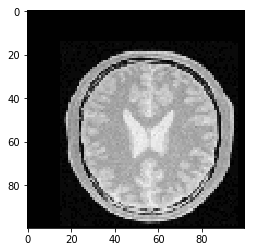

In [4]:
plt.imshow(target)
plt.show()

In [5]:
from Taylor08 import *

In [6]:
px = np.random.random(19)
py = np.random.random(19)


In [7]:
# D = gaussianDeformImage(target, 10, 4, px, py)

In [8]:
# plt.imshow(D)
# plt.show()

In [9]:
(dIm, Ax, Ay, Iz, b, Dx, Dy) = Taylor08(target, base, 10)

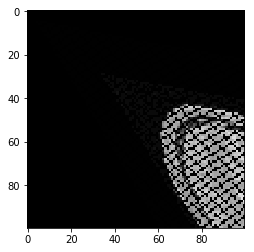

In [10]:
plt.imshow(dIm)
plt.show()

In [11]:
Ax.shape

(77517, 3699)

In [13]:
sum(np.matmul(Ax, Dx) + np.matmul(Ay, Dy) - np.matmul(Iz, np.ones(3699)) <= b)

37059